# Modeling 
In this notebook I will finish preprocessing my data and select the best performing model.

In [26]:
# standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns 

# statsmodels imports
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

# sklearn imports
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, SCORERS
from sklearn.model_selection import RandomizedSearchCV

# turn off warnings
import warnings
warnings.simplefilter('ignore', category = DeprecationWarning)
warnings.simplefilter('ignore', category = FutureWarning)

# plot parameters
plt.rcParams['figure.figsize'] = 20, 16
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 16

# functions from .py file
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
import src.eda_functions as fun

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


read in data files

In [3]:
# training data
train_set = pd.read_csv('../../data/train_set.csv')
fun.to_obj(train_set, 'cohort')

In [4]:
# validation data
val_set = pd.read_csv('../../data/val_set.csv')
fun.to_obj(val_set, 'cohort')

In [5]:
#testing data
test_set = pd.read_csv('../../data/test_set.csv')
fun.to_obj(test_set, 'cohort')

Separate X and y for each set

In [6]:
X_train = train_set.drop('high_school_4_year_graduation_rate_total', axis=1)
y_train = train_set.high_school_4_year_graduation_rate_total

X_val = val_set.drop('high_school_4_year_graduation_rate_total', axis=1)
y_val = val_set.high_school_4_year_graduation_rate_total

X_test = test_set.drop('high_school_4_year_graduation_rate_total', axis=1)
y_test = test_set.high_school_4_year_graduation_rate_total

## Replace NaNs with mean()


Use SimpleImputer to replace NaNs with mean value of respective columns

In [7]:
# identify features
train_num = X_train.select_dtypes(['float64', 'int64'])
val_num = X_val.select_dtypes(['float64', 'int64'])
test_num = X_test.select_dtypes(['float64', 'int64'])

In [8]:
val_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 721 entries, 0 to 720
Data columns (total 18 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   percent_student_enrollment_white                                            721 non-null    float64
 1   percent_student_enrollment_black_or_african_american                        721 non-null    float64
 2   percent_student_enrollment_hispanic_or_latino                               721 non-null    float64
 3   percent_student_enrollment_asian                                            721 non-null    float64
 4   percent_student_enrollment_native_hawaiian_or_other_pacific_islander        721 non-null    float64
 5   percent_student_enrollment_american_indian_or_alaska_native                 721 non-null    float64
 6   percent_student_enrollment_two_or_more_races      

In [9]:
# instatiate imputer
imputer = SimpleImputer(strategy='median')

# fit on the training features
imputer.fit(train_num)

# transform training, validation, and testing data
train_imp= imputer.transform(train_num)
val_imp = imputer.transform(val_num)
test_imp = imputer.transform(test_num)

# return to DataFrame
X_train_imp = pd.DataFrame(train_imp, columns=train_num.columns, index=X_train.index)
X_val_imp = pd.DataFrame(val_imp, columns=val_num.columns, index=X_val.index)
X_test_imp = pd.DataFrame(test_imp, columns=test_num.columns, index=X_test.index)


# Scaling Numeric features
Using Standard Scaler

In [10]:
# identify features
X_train_num = X_train_imp.select_dtypes(['float64', 'int64'])
X_val_num = X_val_imp.select_dtypes(['float64', 'int64'])
X_test_num = X_test_imp.select_dtypes(['float64', 'int64'])

In [13]:
# instatiate scaler
ss = StandardScaler()

# train on the training features
ss.fit(X_train_num)

# transform training, validation, and testing dataX_train_sc= ss.transform(X_train_num)
X_train_sc = ss.transform(X_train_num)
X_val_sc = ss.transform(X_val_num)
X_test_sc = ss.transform(X_test_num)

# return to DataFrames
X_train_sc = pd.DataFrame(X_train_sc, columns=X_train_num.columns, index=X_train.index)
X_val_sc = pd.DataFrame(X_val_sc, columns=X_val_num.columns, index=X_val.index)
X_test_sc = pd.DataFrame(X_test_sc, columns=X_test_num.columns, index=X_test.index)


# Encoding Categorical features

I'm first going to create dfs with objects - and set them as categories for encoding

In [14]:
# identify features
X_train_obj = X_train.select_dtypes(['object']).astype('category')
X_val_obj = X_val.select_dtypes(['object']).astype('category')
X_test_obj = X_test.select_dtypes(['object']).astype('category')

The values in the columns are strings... with varying amounts of white space. 
I'm going to create smaller data frames of the category features with the space stripped away.


In [15]:
X_train_cat = X_train_obj.loc[:, ('district_type', 'district_size', 'school_type')]

X_train_cat.district_type = X_train_obj.district_type.str.rstrip()
X_train_cat.district_size = X_train_obj.district_size.str.rstrip()
X_train_cat.school_type = X_train_cat.school_type.str.rstrip()


In [16]:
X_val_cat = X_val_obj.loc[:, ('district_type', 'district_size', 'school_type')]

X_val_cat.district_type = X_train_obj.district_type.str.rstrip()
X_val_cat.district_size = X_train_obj.district_size.str.rstrip()
X_val_cat.school_type = X_train_cat.school_type.str.rstrip()

In [17]:
X_test_cat = X_test_obj.loc[:, ('district_type', 'district_size', 'school_type')]

X_test_cat.district_type = X_train_obj.district_type.str.rstrip()
X_test_cat.district_size = X_train_obj.district_size.str.rstrip()
X_test_cat.school_type = X_train_cat.school_type.str.rstrip()

That was messy but it worked. I will have to come back to write a function to make this more efficient in the future

In [18]:
#encode the categoricals
ohe = OneHotEncoder(drop='first')

ohe.fit(X_train_cat)

X_train_ohe = ohe.transform(X_train_cat).toarray()
X_val_ohe = ohe.transform(X_val_cat).toarray()
X_test_ohe = ohe.transform(X_test_cat).toarray()

# Creating this DataFrame is not necessary its only to show the result of the ohe
X_train_processed = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names(X_train_cat.columns))
X_val_processed = pd.DataFrame(X_val_ohe, columns=ohe.get_feature_names(X_val_cat.columns))
X_test_processed = pd.DataFrame(X_test_ohe, columns=ohe.get_feature_names(X_test_cat.columns))

In [19]:
X_train_all = pd.concat([X_train_sc, X_train_processed], axis=1)
X_val_all = pd.concat([X_val_sc, X_val_processed], axis=1)
X_test_all = pd.concat([X_test_sc, X_test_processed], axis=1)

# 6. Test models
- Linear Regression
- Random Forest
- Gradient Boost
- Lasso
- Ridge
- SVM
- KNN

This function is a variation on one by Will Koehrsen in his ["Machine Learning Project Walkthrough"](https://github.com/WillKoehrsen/machine-learning-project-walkthrough) series.

In [ ]:
# instantiates, fits, and trains a model.
# returns r2_score
def fit_and_eval(model):
    
    # Train the model
    model.fit(X_train_all, y_train)
    
    # Make predictions and evalute
    model_pred = model.predict(X_val_all)
    model_r2 = r2_score(y_val, model_pred)
    # Return the performance metric
    return model_r2

In [ ]:
linreg = LinearRegression()
linreg_r2 = fit_and_eval(linreg)

print('Linear Regression Performance on the validation set: R2 = %0.3f' % linreg_r2)

In [ ]:
random_forest = RandomForestRegressor(random_state=19)
random_forest_r2 = fit_and_eval(random_forest)

print('Random Forest Performance on the validation set: R2 = %0.3f' % random_forest_r2)

In [ ]:
extra_trees = ExtraTreesRegressor(random_state=19)
extra_trees_r2 = fit_and_eval(extra_trees)

print('Extra Trees Performance on the validation set: R2 = %0.3f' % extra_trees_r2)

In [ ]:
grad_boost = GradientBoostingRegressor(random_state=19)
grad_boost_r2 = fit_and_eval(grad_boost)

print('Gradient Boosting Performance on the validation set: R2 = %0.3f' % grad_boost_r2)

In [ ]:
# Create the model
lasso = Lasso(random_state=19)
lasso_r2 = fit_and_eval(lasso)

print('Lasso model Performance on the validation set: R2 = %0.3f' % lasso_r2)

In [ ]:
ridge = Ridge(random_state=19)
ridge_r2 = fit_and_eval(ridge)

print('Ridge Model Performance on the validation set: R2 = %0.3f' % ridge_r2)

In [ ]:
svr = SVR()
svr_r2 = fit_and_eval(svr)

print('Support Vector Machine Regression Performance on the validation set: R2 = %0.3f' % svr_r2)

In [ ]:
knn = KNeighborsRegressor()
knn_r2 = fit_and_eval(knn)

print('K-Nearest Neighbors Regression Performance on the validation set: R2 = %0.3f' % knn_r2)

# Select best performing model

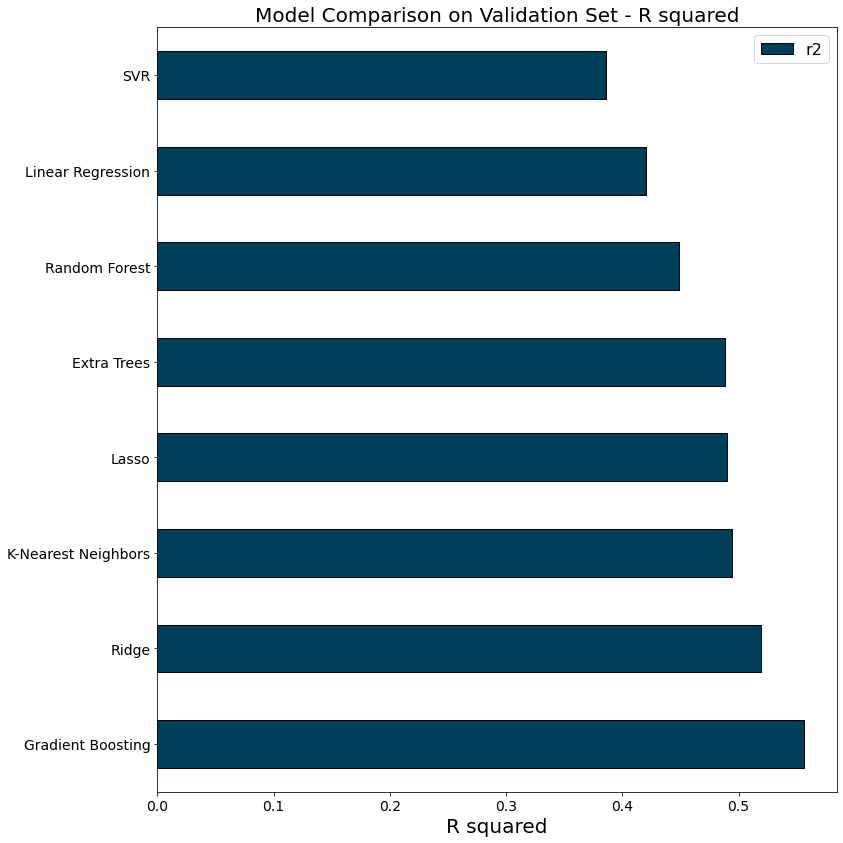

In [70]:
# Dataframe to hold the results
           
model_comparison = pd.DataFrame({'model': ['Linear Regression','Random Forest',
                                           'Extra Trees','Gradient Boosting',
                                           'Lasso', 'Ridge', 'SVR','K-Nearest Neighbors'],
                                 'r2': [linreg_r2, random_forest_r2, extra_trees_r2, 
                                         grad_boost_r2, lasso_r2, ridge_r2, svr_r2, knn_r2]})

# Horizontal bar chart of test r2
model_comparison.sort_values('r2', ascending = False).plot(x = 'model', y = 'r2', kind = 'barh',
                                                           color = '#003f5a', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('R squared'); plt.xticks(size = 14)
plt.title('Model Comparison on Validation Set - R squared', size = 20)
plt.tight_layout()
plt.savefig('../../reports/figures/model_compare.png')
plt.show();


### Results: 
#### Gradient Boosting Regressor returns the highest R-squared value at 0.557.

# Tune hyperparamters with Randomized Search CV

In [20]:
# Loss function to be optimized
loss = ['ls', 'lad', 'huber']

# Number of trees used in the boosting process
n_estimators = [100, 500, 900, 1100, 1500]

# Maximum depth of each tree
max_depth = [2, 3, 5, 10, 15]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6, 10]

# Maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

#### Check out Gradient Boosting best model

In [72]:
# Create the model to use for hyperparameter tuning
model_1 = GradientBoostingRegressor(random_state = 19)

# Set up the random search with 4-fold cross validation
random_cv_1 = RandomizedSearchCV(estimator=model_1,
                               param_distributions=hyperparameter_grid,
                               cv=4, n_iter=25, 
                               scoring = 'r2',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=19)

In [73]:
# Fit on the training data
random_cv_1.fit(X_train_all, y_train)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.7min finished


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
                   estimator=GradientBoostingRegressor(alpha=0.9,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                            

In [74]:
# Find the best combination of settings
random_cv_1.best_estimator_


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features='log2', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=6, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=19, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

#### Evaluate model_1 - Gradient Boosting

In [75]:
model_1 = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features='log2', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=6, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=19, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


model_1_r2 = fit_and_eval(model_1)

print('Model_1 Performance on the validation set: R2 = %0.3f' % model_1_r2)

Model_1 Performance on the validation set: R2 = 0.589


# Evaluate on test set

In [21]:
# Select the best model
final_model = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features='log2', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=6, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=19, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

# Make predictions on the test set using final model
final_model.fit(X_train_all, y_train)
final_pred = final_model.predict(X_test_all)
final_r2 = r2_score(y_test, final_pred)

print('Final Model Performance on the test set: R2 = %0.3f' % final_r2)

Final Model Performance on the test set: R2 = 0.684


# Final model performance has an R-squared score of 0.684.

That is not as high as I had hoped, but for comparison:
- My First Simple Model (OLS Linear Regression) had an R-squared score of 0.445
- The Gradient Boosting model in it's default state  had a score of 0.557.
- The hypertuned Gradient Boosting model had a score of 0.589.

So, the model did improve by approximately 24 percentage points.
The consistency of the final validation score and the test set score suggest that the is neither overfit nor underfit... which is a good result.

# Model interpretation

What does features importance tell us?



In [22]:
feature_results = pd.DataFrame({'feature': list(X_train_all.columns), 
                                'importance': final_model.feature_importances_})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results.head(10)

,feature,importance
0,high_school_5_year_graduation_rate_total,0.340194
1,high_school_dropout_rate_total,0.198619
2,student_attendance_rate,0.087864
3,number_student_enrollment,0.071920
4,student_chronic_truancy_rate,0.071136
5,percent_9th_grade_on_track,0.041907
6,teacher_retention_rate,0.029555
7,total_number_of_school_days,0.027894
8,percent_student_enrollment_black_or_african_am...,0.025764
9,percent_student_enrollment_white,0.022961


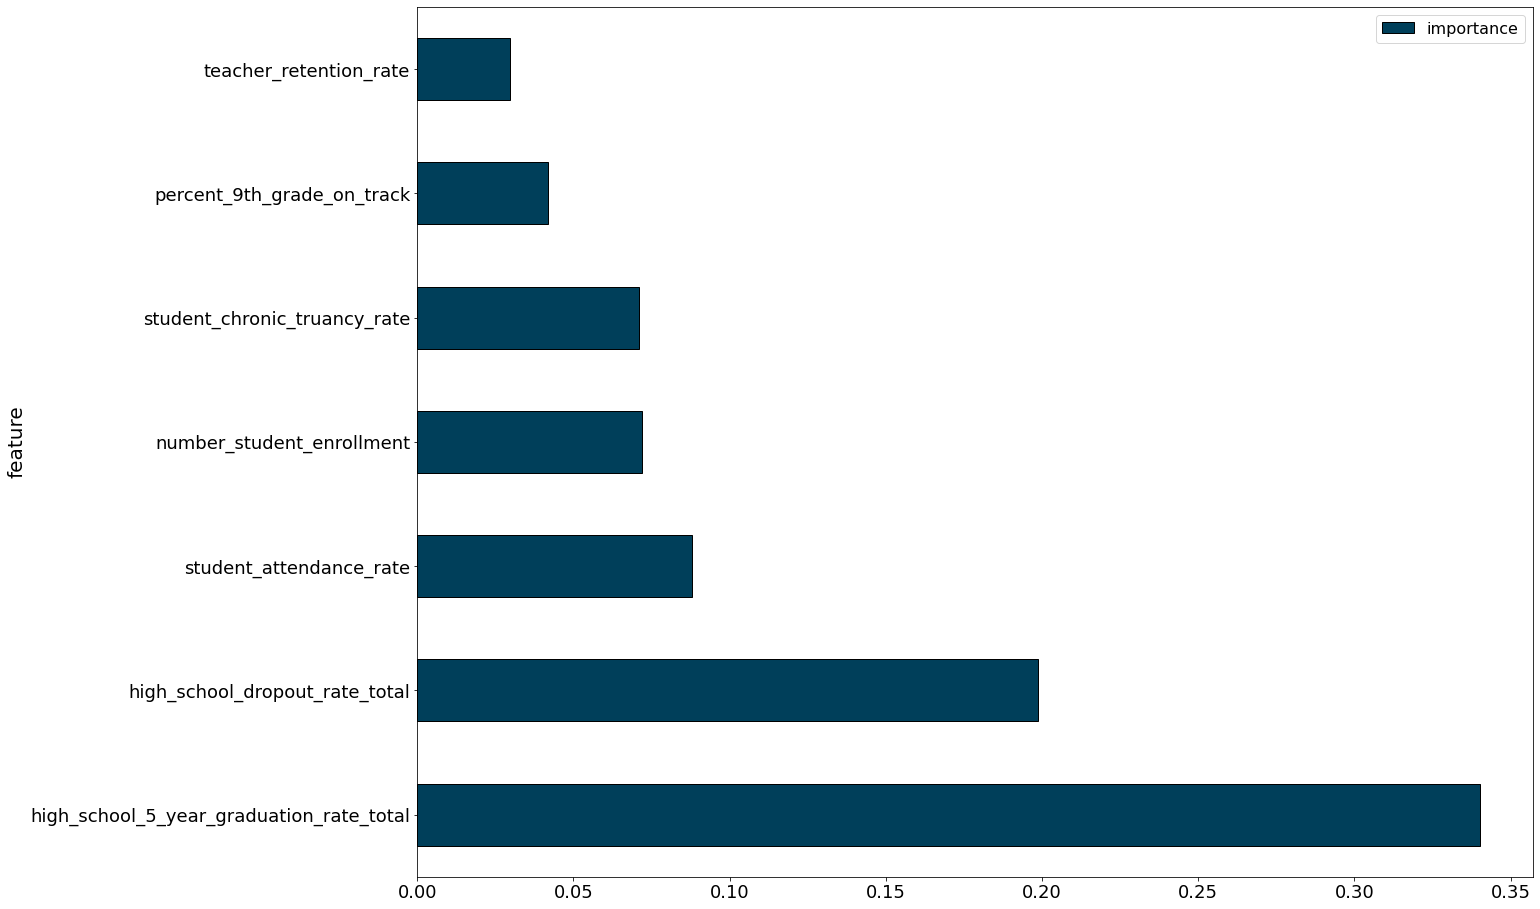

In [27]:
# Plot the 5 most important features in a horizontal bar chart
feature_results.loc[:6, :].plot(x = 'feature', y = 'importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = '#003f5a');
#plt.xlabel('Relative Importance', size = 20); plt.ylabel('')
#plt.title('Feature Importances from Final Model', size = 30)
#plt.tight_layout()
plt.savefig('../../reports/figures/feature_importance.png')
plt.show();

##### Not surprisingly, 5-year graduation has the most importance, followed by droput rate.
It is also worth noting that none of the categorial variables made the top 10.


### Future Improvement Items

I do want to try some additional feature selection and engineering, such as:
- including district level data: pupil to teacher ratio, for one.
- look at spending per student, or property tax information?

For better reproduction, I also want to write some code to filter and combine the data files more effeciently.